cuda
Epoch 1/10.. Train loss: 1.173.. Test loss: 0.906.. Train accuracy: 0.610.. Test accuracy: 0.675
Epoch 2/10.. Train loss: 0.876.. Test loss: 0.851.. Train accuracy: 0.690.. Test accuracy: 0.693
Epoch 3/10.. Train loss: 0.791.. Test loss: 0.795.. Train accuracy: 0.720.. Test accuracy: 0.721
Epoch 4/10.. Train loss: 0.737.. Test loss: 0.736.. Train accuracy: 0.737.. Test accuracy: 0.737
Epoch 5/10.. Train loss: 0.699.. Test loss: 0.721.. Train accuracy: 0.751.. Test accuracy: 0.741
Epoch 6/10.. Train loss: 0.666.. Test loss: 0.706.. Train accuracy: 0.761.. Test accuracy: 0.749
Epoch 7/10.. Train loss: 0.643.. Test loss: 0.692.. Train accuracy: 0.772.. Test accuracy: 0.755
Epoch 8/10.. Train loss: 0.617.. Test loss: 0.672.. Train accuracy: 0.783.. Test accuracy: 0.760
Epoch 9/10.. Train loss: 0.598.. Test loss: 0.664.. Train accuracy: 0.784.. Test accuracy: 0.764
Epoch 10/10.. Train loss: 0.575.. Test loss: 0.668.. Train accuracy: 0.796.. Test accuracy: 0.767
Final Test accuracy: 0.7

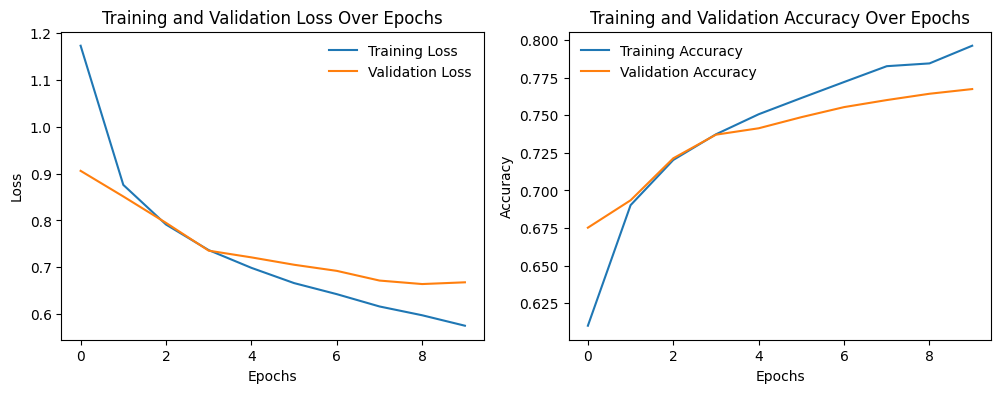

Accuracy of Bicycle : 72.03 %
Accuracy of   Bus : 80.49 %
Accuracy of   Car : 82.26 %
Accuracy of Motorcycle : 71.55 %
Accuracy of NonVehicles : 95.39 %
Accuracy of  Taxi : 22.70 %
Accuracy of Truck : 30.32 %
Accuracy of   Van : 25.49 %


In [1]:
import os
import zipfile
import torch
import torch.nn as nn
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


# Loading the data
with zipfile.ZipFile('vehicle_classification.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

# Transforming the data
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(root='dataset/vehicle_classification', transform=transform)

# Splitting the data into training and testing data with an 8 to 2 ratio
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32,shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining a CNN model
class VehicleClassifier(nn.Module):
    def __init__(self, num_classes):
        super(VehicleClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 16 * 16, 8192)
        self.fc2 = nn.Linear(8192, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = 8  # Number of vehicle classes
model = VehicleClassifier(num_classes)

# Creating loss function and optimization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Moving the model to a specific device (GPU preferred)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Model training and accuracy tracking
epochs = 10
train_losses, test_losses = [], []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    running_loss = 0
    train_accuracy = 0
    correct_train = 0
    total_train = 0
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(logps.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    else:
        test_loss = 0
        test_accuracy = 0
        model.eval()
        with torch.no_grad():
             for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)

                test_loss += batch_loss.item()

                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        model.train()

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
  # Calculating average training and test accuracies
        train_accuracy = correct_train / total_train
        test_accuracy = test_accuracy/len(testloader)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {running_loss/len(trainloader):.3f}.. "
              f"Test loss: {test_loss/len(testloader):.3f}.. "
              f"Train accuracy: {train_accuracy:.3f}.. "
              f"Test accuracy: {test_accuracy:.3f}")

# Printing final accuracies
print(f"Final Test accuracy: {test_accuracy:.3f}")
print(f"Final Train accuracy: {train_accuracy:.3f}")

# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(frameon=False)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')


plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.legend(frameon=False)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')

plt.show()

# Calculating accuracy for each class - This was not part of the
# coding challenge, but I did it out of my curiousity as I was
# wondering exactly how accurate the model was for each class

class_correct = [0] * 8
class_total = [0] * 8
classes = ['Bicycle', 'Bus', 'Car', 'Motorcycle', 'NonVehicles', 'Taxi', 'Truck', 'Van']

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(8):
    accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print('Accuracy of %5s : %2.2f %%' % (classes[i], accuracy))


